# Traffic light detection 
based on [CarND Object Detection Lab](https://github.com/udacity/CarND-Object-Detection-Lab)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
import time
import os

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Frozen inference graph files. NOTE: change the path to where you saved the models.
base_dir = 'frozen_models'
SSD_INCEPTION_GRAPH_FILE = os.path.join(base_dir, 'ssd_inception_v2_coco_2017_11_17', 'frozen_inference_graph.pb')
SSD_MOBILE_V2_GRAPH_FILE = os.path.join(base_dir, 'ssd_mobilenet_v2_coco_2018_03_29', 'frozen_inference_graph.pb')
FASTER_RCNN_GRAPH_FILE = os.path.join(base_dir, 'faster_rcnn_resnet101_coco_2018_01_28', 'frozen_inference_graph.pb')

Below are utility functions. The main purpose of these is to draw the bounding boxes back onto the original image.

In [3]:
# Colors (one for each class)
cmap = ImageColor.colormap
# print("Number of colors =", len(cmap))
COLOR_LIST = sorted([c for c in cmap.keys()])

#
# Utility funcs
#

def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, thickness=4):
    """Draw bounding boxes on the image"""
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)
        
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

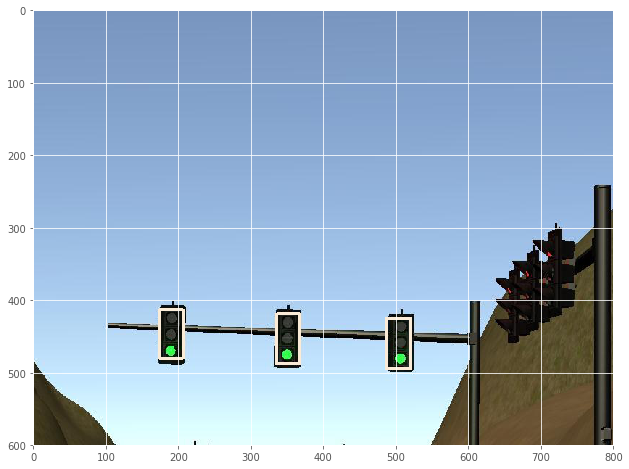

boxes
 [[0.6871415  0.21821408 0.8023165  0.25845578]
 [0.6975914  0.42021552 0.8137493  0.4593437 ]
 [0.70760965 0.60936546 0.8258984  0.6509203 ]]
box coords
 [[412.28488 174.57126 481.3899  206.76463]
 [418.55484 336.17242 488.24957 367.47498]
 [424.5658  487.49237 495.53903 520.7362 ]]
results > min_score_threshold(0.5)
Index 0, Green(class 1.0), score 0.9969685673713684
Index 1, Green(class 1.0), score 0.9874202609062195
Index 2, Green(class 1.0), score 0.8963232040405273


In [4]:
# detection_graph = load_graph(SSD_INCEPTION_GRAPH_FILE)
detection_graph = load_graph(SSD_MOBILE_V2_GRAPH_FILE)
# detection_graph = load_graph(FASTER_RCNN_GRAPH_FILE)

# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Load a sample image.
image = Image.open('./test_images/left0545.jpg')
image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)

with tf.Session(graph=detection_graph) as sess:                
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.8
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = image.size
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw_boxes(image, box_coords, classes)

    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.show()
    
print('boxes\n', boxes)
print('box coords\n', box_coords)
category_index = {1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'Yellow'}, 4: {'id': 4, 'name': 'off'}}

min_score_thresh = 0.5
print('results > min_score_threshold({})'.format(min_score_thresh))
for i in range(boxes.shape[0]):
    if scores is None or scores[i] > min_score_thresh:
        class_name = category_index[classes[i]]['name']
        print('Index {}, {}(class {}), score {}'.format(i, class_name, classes[i], scores[i]))

## Timing Detection

The model zoo comes with a variety of models, each its benefits and costs. Below you'll time some of these models. The general tradeoff being sacrificing model accuracy for seconds per frame (SPF).

In [5]:
def time_detection(sess, img_height, img_width, runs=10):
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')

    # warmup
    gen_image = np.uint8(np.random.randn(1, img_height, img_width, 3))
    sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: gen_image})
    
    times = np.zeros(runs)
    for i in range(runs):
        t0 = time.time()
        sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: image_np})
        t1 = time.time()
        times[i] = (t1 - t0) * 1000
    return times

In [6]:
with tf.Session(graph=detection_graph) as sess:
    times = time_detection(sess, 600, 800, runs=10)

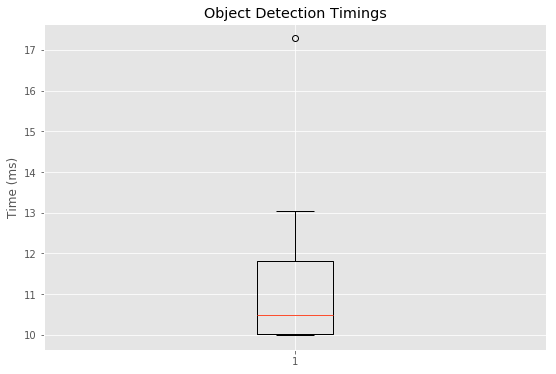

In [7]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
plt.title("Object Detection Timings")
plt.ylabel("Time (ms)")

# Create the boxplot
plt.style.use('fivethirtyeight')
bp = ax.boxplot(times)